In [1]:
import dropbox
import urllib.request, json 
from collections import defaultdict
from collections import OrderedDict
import datetime as DT
import ast
from __future__ import print_function
from __future__ import division
import collections
import nltk
import numpy as np
import scipy.sparse
from string import punctuation
import csv
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

# Helper libraries
from w266_common import utils, vocabulary

########################### DLEE IMPORTS ##################################

# Import pandas and tensorflow
import pandas as pd
import tensorflow as tf
assert(tf.__version__.startswith("1.10"))

# Import model
import models

# Import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import misc
from importlib import reload
import os, sys, re, json, time, datetime, shutil
import itertools
from w266_common import patched_numpy_io

/home/felixtsui/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
##Download the pre-processed tweets from dropbox

access_token = 'p3Ze8FpdRTAAAAAAAAAADb9hCQ8aXXYU3A3gGM1HEXyeMrs8KI2SrA71KDmmCXte'
dbx = dropbox.Dropbox(access_token)



access_token2 = 'm_fKi8mWZ0AAAAAAAAAADlfzTm37f1y45k92Xpiw1B6mjT3dQqzNvKgpIUSR17uq'
dbx2 = dropbox.Dropbox(access_token2)

# #Write the combined file into the drive
with open("InputX.txt", "wb") as f:
    metadata, res = dbx.files_download(path="/Inputdata2.txt")
    metadata2, res2 = dbx2.files_download(path="/Inputdata.txt")
    f.write(res.content)
    f.write(res2.content)

In [2]:
##Translate date of the tweet to quarter reference
def Quarterlookup(date):
    if date>=DT.datetime(2018,10,1):
        return '18Q4'
    elif date>=DT.datetime(2018,7,1):
        return '18Q3'
    elif date>=DT.datetime(2018,4,1):
        return '18Q2'
    elif date>=DT.datetime(2018,1,1):
        return '18Q1'
    elif date>=DT.datetime(2017,10,1):
        return '17Q4'
    elif date>=DT.datetime(2017,7,1):
        return '17Q3'
    elif date>=DT.datetime(2017,4,1):
        return '17Q2'
    elif date>=DT.datetime(2017,1,1):
        return '17Q1'
    elif date>=DT.datetime(2016,10,1):
        return '16Q4'
    elif date>=DT.datetime(2016,7,1):
        return '16Q3'
    elif date>=DT.datetime(2016,4,1):
        return '16Q2'
    elif date>=DT.datetime(2016,1,1):
        return '16Q1'
    elif date>=DT.datetime(2015,10,1):
        return '15Q4'
    elif date>=DT.datetime(2015,7,1):
        return '15Q3'
    elif date>=DT.datetime(2015,4,1):
        return '15Q2'
    else:
        return '15Q1'

In [3]:
##Reading the Input X file and process it
d=defaultdict(list)

with open('InputX.txt') as f:
    for line in f:
        count=0
        temp =-1
        k,v=line.split(':',1)
        while True:
            
            oldtemp=temp
            temp=v.find(']]',temp+1)
            if count==0:
                d[k].append(v[oldtemp+2:temp+2]) 
            else:
                d[k].append(v[oldtemp+4:temp+2])
           
             
            count+=1
            if temp == -1: break
#             if count == 500: break  # initially limit for time sake
    

In [4]:
#Read from the vocab file pre prepared
allword=set()
with open('vocab1.csv', 'r') as f:
    for line in f:
        allword.add(line.strip())

In [5]:
allword=sorted(allword)
vocab = vocabulary.Vocabulary(allword, size=None)  # size=None means unlimited
print("Vocabulary size: {:,}".format(vocab.size))

Vocabulary size: 5,855


In [6]:
def pad_np_array(example_ids, max_len=50, pad_id=0):

    arr = np.full([len(example_ids), max_len], pad_id, dtype=np.int32)
    ns = np.zeros([len(example_ids)], dtype=np.int32)
    cpy_len = min(len(example_ids), max_len)

    arr = example_ids[:cpy_len]
    ns = cpy_len
    return arr, ns

In [7]:
#Dictionary to collect the tweet detail and the length of each tweet
InputX=defaultdict(dict)
InputN=defaultdict(dict)

In [8]:
#Set of all the stocks of interest
trainstock =['CVSHealth', 'RiteAid', "Conn's", "Casey's", 'Kroger','WeisMarkets', 'HavertyFurniture', "Kirkland's", 'Pier1Imports', 'BuildersFirstSource', 'HuttigBuildingProducts', 'LumberLiquidators', 'TransWorldEntertainment', 'MarineMax', 'Medifast', 'SallyBeauty',"Sotheby's", 'StarGasPartners', 'SuburbanPropanePartners', 'TitanMachinery', 'TractorSupply', 'TravelCentersofAmerica', 'Big5SportingGoods', "Dick'sSportingGoods", 'HibbettSports', 'Build-A-BearWorkshop']

#trainstock =['RiteAid']

In [9]:
##Converting the string of data into dictionary


for key,value in d.items():
    Inputx=defaultdict(list)
    Inputn=defaultdict(list)
    if key in trainstock:
        for value2 in value:
        
            temp=value2.find('), ')
            date=value2[14:temp+3]
            try:
                year=int(date[1:5])
                month=int(date[date.find(',')+2:date.find(',',date.find(',')+1)])
                day=int(date[date.find(')')-2:date.find(')')])
            
                sentence, length = pad_np_array (vocab.words_to_ids(ast.literal_eval(value2[temp+3:-1])))
            
                Inputx[Quarterlookup(DT.datetime(year,month,day))].append(sentence)
                Inputn[Quarterlookup(DT.datetime(year,month,day))].append(length)
            except:
                pass

    InputX[key]=OrderedDict(sorted(Inputx.items()))
    InputN[key]=OrderedDict(sorted(Inputn.items()))

In [10]:
##List of stockname and relevant stock code
l = [("CVSHealth", "CVS"),
("RiteAid", "RAD"),
("Conn's", "CONN"),
("Casey's", "CASY"),
("Kroger", "KR"),
("WeisMarkets", "WMK"),
("HavertyFurniture", "HVT"),
("Kirkland's", "KIRK"),
("Pier1Imports","PIR"),
("BuildersFirstSource","BLDR"),
("HuttigBuildingProducts", "HBP"),
("LumberLiquidators", "LL"),
("TransWorldEntertainment", "TWMC"),
("MarineMax", "HZO"),
("Medifast", "MED"),
("SallyBeauty", "SBH"),
("Sotheby's", "BID"),
("StarGasPartners", "SGU"),
("SuburbanPropanePartners", "SPH"),
("TitanMachinery", "TITN"),
("TractorSupply","TSCO"),
("TravelCentersofAmerica", "TA"),
("Big5SportingGoods", "BGFV"),
("Dick'sSportingGoods", "DKS"),
("HibbettSports", "HIBB"),
("Build-A-BearWorkshop", "BBW")]
     
all_stock = {}
[all_stock.update({k:v}) for k,v in l]
print(all_stock)

{'CVSHealth': 'CVS', 'RiteAid': 'RAD', "Conn's": 'CONN', "Casey's": 'CASY', 'Kroger': 'KR', 'WeisMarkets': 'WMK', 'HavertyFurniture': 'HVT', "Kirkland's": 'KIRK', 'Pier1Imports': 'PIR', 'BuildersFirstSource': 'BLDR', 'HuttigBuildingProducts': 'HBP', 'LumberLiquidators': 'LL', 'TransWorldEntertainment': 'TWMC', 'MarineMax': 'HZO', 'Medifast': 'MED', 'SallyBeauty': 'SBH', "Sotheby's": 'BID', 'StarGasPartners': 'SGU', 'SuburbanPropanePartners': 'SPH', 'TitanMachinery': 'TITN', 'TractorSupply': 'TSCO', 'TravelCentersofAmerica': 'TA', 'Big5SportingGoods': 'BGFV', "Dick'sSportingGoods": 'DKS', 'HibbettSports': 'HIBB', 'Build-A-BearWorkshop': 'BBW'}


In [41]:
##Read the quarterly return detail from edgaronline and convert into library
top="http://datafied.api.edgar-online.com/v2/corefinancials/qtr?primarysymbols="
bottom="&appkey=asc97xrhkyu4959aptu76zxj"
Outputy =defaultdict(dict)
for stockname,stock in all_stock.items():
    check=top+stock+bottom
    with urllib.request.urlopen(check) as url:
        data = json.loads(url.read().decode())
    count1=0
    count2=0
    end_date=[]
    revenue_change=[]
    last_revQ1=0
    last_revQ2=0
    last_revQ3=0
    last_revQ4=0

    for key, value in data.items():
        
        for key2, value2 in value.items():          
        
            if count1!=0:  
                for i in reversed(value2):
                  
                    for j in i["values"]:
                     
                        if count2>3:   
                            if j["field"] =="periodenddate":
                                end_date.append(Quarterlookup(DT.datetime.strptime(j['value'], '%m/%d/%Y')))
                       
                            ##Convert revenue into the y_label of 0 for negative growth and 1 for positive growth
                            if j["field"] =="totalrevenue":
                                if count2%4==0: 
                                    revenue_cal =round(float(j['value'])/float(last_revQ1) - 1,3)
                                    last_revQ1=j['value']
                                    if revenue_cal>0.1:
                                        revenue_change.append(3)
                                    elif revenue_cal>0:
                                        revenue_change.append(2)
                                    elif revenue_cal>-0.1:
                                        revenue_change.append(1)
                                    else:
                                        revenue_change.append(0)
                                elif count2%4==1: 
                                    revenue_cal =round(float(j['value'])/float(last_revQ2) - 1,3)
                                    last_revQ2=j['value']
                                    if revenue_cal>0.1:
                                        revenue_change.append(3)
                                    elif revenue_cal>0:
                                        revenue_change.append(2)
                                    elif revenue_cal>-0.1:
                                        revenue_change.append(1)
                                    else:
                                        revenue_change.append(0)
                                elif count2%4==2: 
                                    revenue_cal =round(float(j['value'])/float(last_revQ3) - 1,3)
                                    last_revQ3=j['value']
                                    if revenue_cal>0.1:
                                        revenue_change.append(3)
                                    elif revenue_cal>0:
                                        revenue_change.append(2)
                                    elif revenue_cal>-0.1:
                                        revenue_change.append(1)
                                    else:
                                        revenue_change.append(0)
                                else: 
                                    revenue_cal =round(float(j['value'])/float(last_revQ4) - 1,3)
                                    last_revQ4=j['value']
                                    if revenue_cal>0.1:
                                        revenue_change.append(3)
                                    elif revenue_cal>0:
                                        revenue_change.append(2)
                                    elif revenue_cal>-0.1:
                                        revenue_change.append(1)
                                    else:
                                        revenue_change.append(0)
                                    
                        elif count2==1:
                            if j["field"] =="totalrevenue":      
                                last_revQ2=j['value']                            
                        elif count2==2:
                            if j["field"] =="totalrevenue":      
                                last_revQ3=j['value']                            
                        elif count2==3:
                            if j["field"] =="totalrevenue":      
                                last_revQ4=j['value']                            
                        else:
                            
                            if j["field"] =="totalrevenue":      
                                last_revQ1=j['value']
                              
                    count2+=1

            count1+=1
            
    ##Output will be a dictionary with stockname
    Outputy[stockname]["period"]=end_date
    Outputy[stockname]["revenuechange"]=revenue_change

In [42]:
y_keys = list(Outputy.keys())
print(y_keys)

['CVSHealth', 'RiteAid', "Conn's", "Casey's", 'Kroger', 'WeisMarkets', 'HavertyFurniture', "Kirkland's", 'Pier1Imports', 'BuildersFirstSource', 'HuttigBuildingProducts', 'LumberLiquidators', 'TransWorldEntertainment', 'MarineMax', 'Medifast', 'SallyBeauty', "Sotheby's", 'StarGasPartners', 'SuburbanPropanePartners', 'TitanMachinery', 'TractorSupply', 'TravelCentersofAmerica', 'Big5SportingGoods', "Dick'sSportingGoods", 'HibbettSports', 'Build-A-BearWorkshop']


In [57]:
print(Outputy[y_keys[1]])

{'period': ['15Q4', '16Q1', '16Q2', '16Q3', '16Q4', '17Q1', '17Q2', '17Q3', '17Q4', '18Q1', '18Q2', '18Q3'], 'revenuechange': [3, 0, 3, 2, 0, 0, 0, 0, 1, 1, 1, 2]}


In [ ]:
with open('Outputy.txt', 'w') as f:
    print(Outputy, file=f)

In [125]:
train_x_init = []
train_n_init = []
train_y_init = []
dev_x_init = []
dev_n_init = []
dev_y_init = []
test_x_init = []
test_n_init = []
test_y_init = []


In [126]:
trainquarter=['16Q1','16Q2','16Q3','16Q4','17Q1','17Q2','17Q3','17Q4','18Q1']

for i in trainstock:
    for j in range(len(trainquarter)):
        try:
                train_x_init.append(InputX [i][trainquarter[j]])
                train_n_init.append(InputN [i][trainquarter[j]])
                length=len(InputN [i][trainquarter[j]])           
                train_y_init.append([Outputy [i]['revenuechange'][j]]*length)
      
        except:
            pass



In [127]:
teststock =['CVSHealth', 'RiteAid', "Conn's", "Casey's", 'Kroger','WeisMarkets', 'HavertyFurniture', "Kirkland's", 'Pier1Imports', 'BuildersFirstSource', 'HuttigBuildingProducts', 'LumberLiquidators', 'TransWorldEntertainment', 'MarineMax', 'Medifast', 'SallyBeauty',"Sotheby's", 'StarGasPartners', 'SuburbanPropanePartners', 'TitanMachinery', 'TractorSupply', 'TravelCentersofAmerica', 'Big5SportingGoods', "Dick'sSportingGoods", 'HibbettSports', 'Build-A-BearWorkshop']
#teststock =['RiteAid']
testquarter=['18Q2','18Q3']

for i in teststock:
    for j in range(len(testquarter)):
      
        try:
            if testquarter[j]=='18Q3':
                test_x_init.append(InputX [i][testquarter[j]])
                test_n_init.append(InputN [i][testquarter[j]])
                length=len(InputN [i][testquarter[j]])
                test_y_init.append([Outputy [i]['revenuechange'][j]]*length)   
            
            elif testquarter[j]=='18Q2':
                dev_x_init.append(InputX [i][testquarter[j]])
                dev_n_init.append(InputN [i][testquarter[j]])
                length=len(InputN [i][testquarter[j]])
                dev_y_init.append([Outputy [i]['revenuechange'][j]]*length)     
               
      
        except:
            pass

In [128]:
print(len(test_y_init))

26


In [129]:
#lbl, cnts = np.unique(Outputy['RiteAid']['revenuechange']['18Q3'], return_counts=True)
lbl2, cnts2 = np.unique(test_y_init[1], return_counts=True)
#print(lbl,cnts)
print(lbl2,cnts2)


[0] [16608]


In [130]:
counttest=[]

for i in range(len(test_y_init)):
    
    counttest.append(len(test_y_init[i]))


In [62]:

train_x_init2 = []
train_n_init2 = []
train_y_init2 = []
dev_x_init2 = []
dev_n_init2 = []
dev_y_init2 = []
test_x_init2 = []
test_n_init2 = []
test_y_init2 = []

for i in range(len(train_x_init)):
    for j in range(len(train_x_init[i])):
     
        train_x_init2.append(train_x_init[i][j])
        train_n_init2.append(train_n_init[i][j])
        train_y_init2.append(train_y_init[i][j])
        
for i in range(len(dev_x_init)):
    for j in range(len(dev_x_init[i])):
        dev_x_init2.append(dev_x_init[i][j])
        dev_n_init2.append(dev_n_init[i][j])
        dev_y_init2.append(dev_y_init[i][j])
        
for i in range(len(test_x_init)):
    for j in range(len(test_x_init[i])):
        test_x_init2.append(test_x_init[i][j])
        test_n_init2.append(test_n_init[i][j])
        test_y_init2.append(test_y_init[i][j])



# NEURAL BAG OF WORDS MODEL #

In [137]:
lbl2, cnts2 = np.unique(test_y_init2[3739:16608+3739], return_counts=True)
#print(lbl,cnts)
print(lbl2,cnts2)



[0] [16608]


In [63]:
def pad_np_array2(example_ids, max_len=50, pad_id=0):

    arr = np.full([len(example_ids), max_len], pad_id, dtype=np.int32)
    ns = np.zeros([len(example_ids)], dtype=np.int32)
    for i, ids in enumerate(example_ids):
        cpy_len = min(len(ids), max_len)
        arr[i,:cpy_len] = ids[:cpy_len]
        ns[i] = cpy_len
    return arr ##I HAD TO REMOVE NS TO MAKE IT WORK< PLEASE TAKE A LOOK IF IT HAS ANY IMPACT

In [64]:
train_x = pad_np_array2(train_x_init2, max_len = 50, pad_id=0)
train_n = np.array(train_n_init2)
train_y = np.array(train_y_init2)

test_x = pad_np_array2(test_x_init2, max_len = 50, pad_id=0)
test_n = np.array(test_n_init2)
test_y = np.array(test_y_init2)

dev_x = pad_np_array2(dev_x_init2, max_len = 50, pad_id=0)
dev_n = np.array(dev_n_init2)
dev_y = np.array(dev_y_init2)

In [138]:
lbl2, cnts2 = np.unique(test_y[3739:16608+3739], return_counts=True)
#print(lbl,cnts)
print(lbl2,cnts2)

[0] [16608]


[(0, 162441), (1, 125592), (2, 153503), (3, 76920)]
[0 1 2 3]
[162441 125592 153503  76920]


([array([162441.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.]),
  array([     0.,      0.,      0., 125592.,      0.,      0.,      0.,
              0.,      0.,      0.]),
  array([     0.,      0.,      0.,      0.,      0.,      0., 153503.,
              0.,      0.,      0.]),
  array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 76920.])],
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 4 Lists of Patches objects>)

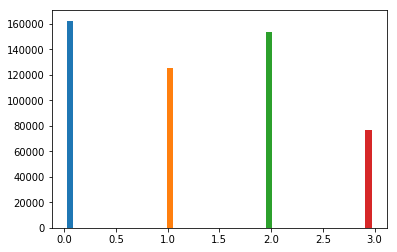

In [67]:
lbl, cnts = np.unique(test_y, return_counts=True)
print(list(zip(lbl, cnts)))
print(lbl)
print(cnts)

# labels = 
# counts = 

plt.hist((cnts[0]*[lbl[0]],cnts[1]*[lbl[1]],cnts[2]*[lbl[2]],cnts[3]*[lbl[3]]))

[(0, 564610), (1, 1252876), (2, 1701111), (3, 1115693)]
0
564610


([array([564610.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.]),
  array([      0.,       0.,       0., 1252876.,       0.,       0.,
               0.,       0.,       0.,       0.]),
  array([     0.,      0.,      0.,      0.,      0.,      0., 153503.,
              0.,      0.,      0.]),
  array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 76920.])],
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 4 Lists of Patches objects>)

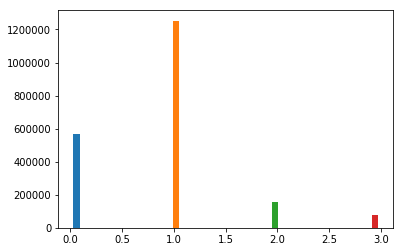

In [68]:
lbl2, cnts2 = np.unique(train_y, return_counts=True)
print(list(zip(lbl2, cnts2)))
print(lbl2[0])
print(cnts2[0])

# labels = 
# counts = 

plt.hist((cnts2[0]*[lbl2[0]],cnts2[1]*[lbl2[1]],cnts[2]*[lbl[2]],cnts[3]*[lbl[3]]))


In [149]:
reload(models)

x, ns, y = train_x, train_n, train_y
batch_size = 125

# Specify model hyperparameters as used by model_fn
model_params = dict(V=vocab.size, embed_dim=500, hidden_dims=[50,50], num_classes=4,
                    encoder_type='bow',
                    lr=0.01, optimizer='adagrad', beta=0.01)
model_fn = models.classifier_model_fn

total_batches = 0
total_examples = 0
total_loss = 0
loss_ema = np.log(2)  # track exponential-moving-average of loss
ema_decay = np.exp(-1/10)  # decay parameter for moving average = np.exp(-1/history_length)
with tf.Graph().as_default(), tf.Session() as sess:
    ##
    # Construct the graph here. No session.run calls - just wiring up Tensors.
    ##
    # Add placeholders so we can feed in data.
    x_ph_  = tf.placeholder(tf.int32, shape=[None, x.shape[1]])  # [batch_size, max_len]
    ns_ph_ = tf.placeholder(tf.int32, shape=[None])              # [batch_size]
    y_ph_  = tf.placeholder(tf.int32, shape=[None])              # [batch_size]
    
    # Construct the graph using model_fn
    features = {"ids": x_ph_, "ns": ns_ph_}  # note that values are Tensors
    estimator_spec = model_fn(features, labels=y_ph_, mode=tf.estimator.ModeKeys.TRAIN,
                              params=model_params)
    loss_     = estimator_spec.loss
    train_op_ = estimator_spec.train_op
    
    ##
    # Done constructing the graph, now we can make session.run calls.
    ##
    sess.run(tf.global_variables_initializer())
    
    # Run a single epoch
    t0 = time.time()
    for (bx, bns, by) in utils.multi_batch_generator(batch_size, x, ns, y):
        # feed NumPy arrays into the placeholder Tensors
        feed_dict = {x_ph_: bx, ns_ph_: bns, y_ph_: by}
        batch_loss, _ = sess.run([loss_, train_op_], feed_dict=feed_dict)
        
        # Compute some statistics
        total_batches += 1
        total_examples += len(bx)
        total_loss += batch_loss * len(bx)  # re-scale, since batch loss is mean
        # Compute moving average to smooth out noisy per-batch loss
        loss_ema = ema_decay * loss_ema + (1 - ema_decay) * batch_loss
        
        if (total_batches % 125 == 0):
            print("{:5,} examples, moving-average loss {:.2f}".format(total_examples, 
                                                                      loss_ema))    
    print("Completed one epoch in {:s}".format(utils.pretty_timedelta(since=t0)))

15,625 examples, moving-average loss 1.66
31,250 examples, moving-average loss 1.87
46,875 examples, moving-average loss 1.46
62,500 examples, moving-average loss 1.39
78,125 examples, moving-average loss 1.30
93,750 examples, moving-average loss 1.25
109,375 examples, moving-average loss 1.18
125,000 examples, moving-average loss 1.11
140,625 examples, moving-average loss 1.06
156,250 examples, moving-average loss 1.00
171,875 examples, moving-average loss 1.01
187,500 examples, moving-average loss 0.96
203,125 examples, moving-average loss 0.89
218,750 examples, moving-average loss 0.85
234,375 examples, moving-average loss 0.81
250,000 examples, moving-average loss 0.79
265,625 examples, moving-average loss 0.75
281,250 examples, moving-average loss 0.72
296,875 examples, moving-average loss 0.69
312,500 examples, moving-average loss 0.66
328,125 examples, moving-average loss 0.63
343,750 examples, moving-average loss 0.61
359,375 examples, moving-average loss 0.66
375,000 examples,

2,906,250 examples, moving-average loss 0.19
2,921,875 examples, moving-average loss 0.18
2,937,500 examples, moving-average loss 0.32
2,953,125 examples, moving-average loss 0.21
2,968,750 examples, moving-average loss 0.19
2,984,375 examples, moving-average loss 0.18
3,000,000 examples, moving-average loss 0.19
3,015,625 examples, moving-average loss 0.18
3,031,250 examples, moving-average loss 0.18
3,046,875 examples, moving-average loss 0.22
3,062,500 examples, moving-average loss 0.20
3,078,125 examples, moving-average loss 0.19
3,093,750 examples, moving-average loss 0.31
3,109,375 examples, moving-average loss 0.18
3,125,000 examples, moving-average loss 0.17
3,140,625 examples, moving-average loss 0.17
3,156,250 examples, moving-average loss 0.22
3,171,875 examples, moving-average loss 0.22
3,187,500 examples, moving-average loss 0.17
3,203,125 examples, moving-average loss 0.17
3,218,750 examples, moving-average loss 0.16
3,234,375 examples, moving-average loss 0.18
3,250,000 

In [150]:
import models; reload(models)

# Specify model hyperparameters as used by model_fn
model_params = dict(V=vocab.size, embed_dim=500, hidden_dims=[50,50], num_classes=4,
                    encoder_type='bow',
                    lr=0.01, optimizer='adagrad', beta=0.01)

checkpoint_dir = "/tmp/tf_bow_sst_" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
# Write vocabulary to file, so TensorBoard can label embeddings.
# creates checkpoint_dir/projector_config.pbtxt and checkpoint_dir/metadata.tsv
vocab.write_projector_config(checkpoint_dir, "Encoder/Embedding_Layer/W_embed")

model = tf.estimator.Estimator(model_fn=models.classifier_model_fn, 
                               params=model_params,
                               model_dir=checkpoint_dir)
print("")
print("To view training (once it starts), run:\n")
print("    tensorboard --logdir='{:s}' --port 6006".format(checkpoint_dir))
print("\nThen in your browser, open: http://localhost:6006")

Vocabulary (5,855 words) written to '/tmp/tf_bow_sst_20181208-0944/metadata.tsv'
Projector config written to /tmp/tf_bow_sst_20181208-0944/projector_config.pbtxt
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tf_bow_sst_20181208-0944', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f04a8f5f6d8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

To view training (once it starts), run:

    tensorboard --logdir='/tmp/tf_bow_sst_20181208-0944' --port 6006

Then in your browser, open: http:

In [ ]:
# Training params, just used in this cell for the input_fn-s
train_params = dict(batch_size=125, total_epochs=10, eval_every=2)
assert(train_params['total_epochs'] % train_params['eval_every'] == 0)

# Construct and train the model, saving checkpoints to the directory above.
# Input function for training set batches
# Do 'eval_every' epochs at once, followed by evaluating on the dev set.
# NOTE: use patch_numpy_io.numpy_input_fn instead of tf.estimator.inputs.numpy_input_fn
train_input_fn = patched_numpy_io.numpy_input_fn(
                    x={"ids": train_x, "ns": train_n}, y=train_y,
                    batch_size=train_params['batch_size'], 
                    num_epochs=train_params['eval_every'], shuffle=True, seed=42
                 )

# Input function for dev set batches. As above, but:
# - Don't randomize order
# - Iterate exactly once (one epoch)
dev_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": dev_x, "ns": dev_n}, y=dev_y,
                    batch_size=125, num_epochs=1, shuffle=False
                )

for _ in range(train_params['total_epochs'] // train_params['eval_every']):
    # Train for a few epochs, then evaluate on dev
    model.train(input_fn=train_input_fn)
    eval_metrics = model.evaluate(input_fn=dev_input_fn, name="dev")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tf_bow_sst_20181208-0944/model.ckpt.
INFO:tensorflow:loss = 2.9249184, step = 1
INFO:tensorflow:global_step/sec: 36.3913
INFO:tensorflow:loss = 1.4835075, step = 101 (2.751 sec)
INFO:tensorflow:global_step/sec: 37.7563
INFO:tensorflow:loss = 1.3985615, step = 201 (2.650 sec)
INFO:tensorflow:global_step/sec: 37.8249
INFO:tensorflow:loss = 1.3221442, step = 301 (2.642 sec)
INFO:tensorflow:global_step/sec: 37.6706
INFO:tensorflow:loss = 1.2534332, step = 401 (2.655 sec)
INFO:tensorflow:global_step/sec: 37.8717
INFO:tensorflow:loss = 1.1889216, step = 501 (2.641 sec)
INFO:tensorflow:global_step/sec: 38.2474
INFO:tensorflow:loss = 1.129699, step = 601 (2.614 sec)
INFO:tensorflow:global_step/sec: 38.126
INFO:

INFO:tensorflow:global_step/sec: 36.2602
INFO:tensorflow:loss = 0.21394004, step = 8001 (2.760 sec)
INFO:tensorflow:global_step/sec: 36.4588
INFO:tensorflow:loss = 0.20923348, step = 8101 (2.740 sec)
INFO:tensorflow:global_step/sec: 36.9363
INFO:tensorflow:loss = 0.2034099, step = 8201 (2.709 sec)
INFO:tensorflow:global_step/sec: 36.2386
INFO:tensorflow:loss = 0.19965939, step = 8301 (2.759 sec)
INFO:tensorflow:global_step/sec: 36.5434
INFO:tensorflow:loss = 0.1957209, step = 8401 (2.736 sec)
INFO:tensorflow:global_step/sec: 35.4664
INFO:tensorflow:loss = 0.20291959, step = 8501 (2.820 sec)
INFO:tensorflow:global_step/sec: 35.9577
INFO:tensorflow:loss = 1.0522598, step = 8601 (2.781 sec)
INFO:tensorflow:global_step/sec: 36.2761
INFO:tensorflow:loss = 0.19269389, step = 8701 (2.757 sec)
INFO:tensorflow:global_step/sec: 35.9947
INFO:tensorflow:loss = 0.18479344, step = 8801 (2.778 sec)
INFO:tensorflow:global_step/sec: 35.6814
INFO:tensorflow:loss = 0.17992361, step = 8901 (2.803 sec)
INF

INFO:tensorflow:global_step/sec: 36.9505
INFO:tensorflow:loss = 0.2219289, step = 16201 (2.706 sec)
INFO:tensorflow:global_step/sec: 36.2262
INFO:tensorflow:loss = 0.18146704, step = 16301 (2.761 sec)
INFO:tensorflow:global_step/sec: 36.9418
INFO:tensorflow:loss = 0.1728064, step = 16401 (2.707 sec)
INFO:tensorflow:global_step/sec: 37.0425
INFO:tensorflow:loss = 0.20270076, step = 16501 (2.700 sec)
INFO:tensorflow:global_step/sec: 36.7999
INFO:tensorflow:loss = 0.18774562, step = 16601 (2.717 sec)
INFO:tensorflow:global_step/sec: 37.5104
INFO:tensorflow:loss = 0.18051504, step = 16701 (2.666 sec)
INFO:tensorflow:global_step/sec: 36.6752
INFO:tensorflow:loss = 0.17517883, step = 16801 (2.727 sec)
INFO:tensorflow:global_step/sec: 35.882
INFO:tensorflow:loss = 0.23347424, step = 16901 (2.789 sec)
INFO:tensorflow:global_step/sec: 35.4584
INFO:tensorflow:loss = 0.20383547, step = 17001 (2.821 sec)
INFO:tensorflow:global_step/sec: 30.7439
INFO:tensorflow:loss = 0.19181888, step = 17101 (3.25

INFO:tensorflow:global_step/sec: 21.0757
INFO:tensorflow:loss = 0.17880358, step = 24301 (4.740 sec)
INFO:tensorflow:global_step/sec: 26.5125
INFO:tensorflow:loss = 0.16886155, step = 24401 (3.772 sec)
INFO:tensorflow:global_step/sec: 26.3826
INFO:tensorflow:loss = 0.16869555, step = 24501 (3.790 sec)
INFO:tensorflow:global_step/sec: 26.9799
INFO:tensorflow:loss = 0.1654083, step = 24601 (3.706 sec)
INFO:tensorflow:global_step/sec: 27.2286
INFO:tensorflow:loss = 0.15836455, step = 24701 (3.673 sec)
INFO:tensorflow:global_step/sec: 27.3845
INFO:tensorflow:loss = 0.1874911, step = 24801 (3.652 sec)
INFO:tensorflow:global_step/sec: 26.5662
INFO:tensorflow:loss = 0.16418739, step = 24901 (3.765 sec)
INFO:tensorflow:global_step/sec: 26.8957
INFO:tensorflow:loss = 0.15812118, step = 25001 (3.716 sec)
INFO:tensorflow:global_step/sec: 25.4642
INFO:tensorflow:loss = 0.15487206, step = 25101 (3.928 sec)
INFO:tensorflow:global_step/sec: 23.597
INFO:tensorflow:loss = 0.18005487, step = 25201 (4.23

INFO:tensorflow:global_step/sec: 26.9108
INFO:tensorflow:loss = 0.19735058, step = 32501 (3.713 sec)
INFO:tensorflow:global_step/sec: 26.7546
INFO:tensorflow:loss = 0.17121056, step = 32601 (3.739 sec)
INFO:tensorflow:global_step/sec: 26.7316
INFO:tensorflow:loss = 0.1640181, step = 32701 (3.744 sec)
INFO:tensorflow:global_step/sec: 27.2145
INFO:tensorflow:loss = 0.40605205, step = 32801 (3.674 sec)
INFO:tensorflow:global_step/sec: 27.6845
INFO:tensorflow:loss = 0.22830845, step = 32901 (3.609 sec)
INFO:tensorflow:global_step/sec: 26.6193
INFO:tensorflow:loss = 1.9859681, step = 33001 (3.757 sec)
INFO:tensorflow:global_step/sec: 27.2258
INFO:tensorflow:loss = 0.26877087, step = 33101 (3.673 sec)
INFO:tensorflow:global_step/sec: 26.9946
INFO:tensorflow:loss = 0.18549581, step = 33201 (3.708 sec)
INFO:tensorflow:global_step/sec: 25.9397
INFO:tensorflow:loss = 0.19312155, step = 33301 (3.856 sec)
INFO:tensorflow:global_step/sec: 24.8722
INFO:tensorflow:loss = 0.29503152, step = 33401 (4.0

INFO:tensorflow:global_step/sec: 30.2664
INFO:tensorflow:loss = 0.155805, step = 40601 (3.304 sec)
INFO:tensorflow:global_step/sec: 29.8541
INFO:tensorflow:loss = 0.43571746, step = 40701 (3.350 sec)
INFO:tensorflow:global_step/sec: 23.7454
INFO:tensorflow:loss = 0.13729991, step = 40801 (4.211 sec)
INFO:tensorflow:global_step/sec: 27.3486
INFO:tensorflow:loss = 0.13379253, step = 40901 (3.657 sec)
INFO:tensorflow:global_step/sec: 26.9345
INFO:tensorflow:loss = 0.1306212, step = 41001 (3.712 sec)
INFO:tensorflow:global_step/sec: 24.2286
INFO:tensorflow:loss = 0.516064, step = 41101 (4.127 sec)
INFO:tensorflow:global_step/sec: 26.486
INFO:tensorflow:loss = 0.15362029, step = 41201 (3.776 sec)
INFO:tensorflow:global_step/sec: 26.5048
INFO:tensorflow:loss = 0.67366296, step = 41301 (3.773 sec)
INFO:tensorflow:global_step/sec: 25.9801
INFO:tensorflow:loss = 0.13473725, step = 41401 (3.849 sec)
INFO:tensorflow:global_step/sec: 26.4434
INFO:tensorflow:loss = 0.13097514, step = 41501 (3.782 s

INFO:tensorflow:loss = 0.15642905, step = 48701 (4.594 sec)
INFO:tensorflow:global_step/sec: 21.9794
INFO:tensorflow:loss = 0.14487311, step = 48801 (4.549 sec)
INFO:tensorflow:global_step/sec: 21.7392
INFO:tensorflow:loss = 0.13760681, step = 48901 (4.603 sec)
INFO:tensorflow:global_step/sec: 21.955
INFO:tensorflow:loss = 0.13595282, step = 49001 (4.551 sec)
INFO:tensorflow:global_step/sec: 21.9033
INFO:tensorflow:loss = 0.13077292, step = 49101 (4.566 sec)
INFO:tensorflow:global_step/sec: 21.5552
INFO:tensorflow:loss = 0.17064092, step = 49201 (4.639 sec)
INFO:tensorflow:global_step/sec: 21.9026
INFO:tensorflow:loss = 0.14108989, step = 49301 (4.566 sec)
INFO:tensorflow:global_step/sec: 21.5518
INFO:tensorflow:loss = 0.13952228, step = 49401 (4.640 sec)
INFO:tensorflow:global_step/sec: 20.6849
INFO:tensorflow:loss = 0.13038415, step = 49501 (4.835 sec)
INFO:tensorflow:global_step/sec: 20.1351
INFO:tensorflow:loss = 0.16500309, step = 49601 (4.969 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 22.191
INFO:tensorflow:loss = 0.14078817, step = 56801 (4.493 sec)
INFO:tensorflow:global_step/sec: 16.7225
INFO:tensorflow:loss = 0.20407438, step = 56901 (5.986 sec)
INFO:tensorflow:global_step/sec: 22.388
INFO:tensorflow:loss = 0.1768822, step = 57001 (4.461 sec)
INFO:tensorflow:global_step/sec: 21.8128
INFO:tensorflow:loss = 0.18495111, step = 57101 (4.584 sec)
INFO:tensorflow:global_step/sec: 21.6436
INFO:tensorflow:loss = 0.1754463, step = 57201 (4.621 sec)
INFO:tensorflow:global_step/sec: 22.1104
INFO:tensorflow:loss = 0.18090704, step = 57301 (4.523 sec)
INFO:tensorflow:global_step/sec: 21.8851
INFO:tensorflow:loss = 1.0505805, step = 57401 (4.570 sec)
INFO:tensorflow:global_step/sec: 21.9792
INFO:tensorflow:loss = 0.17473847, step = 57501 (4.548 sec)
INFO:tensorflow:global_step/sec: 21.5783
INFO:tensorflow:loss = 0.16350386, step = 57601 (4.635 sec)
INFO:tensorflow:global_step/sec: 21.161
INFO:tensorflow:loss = 0.15787426, step = 57701 (4.725 s

INFO:tensorflow:global_step/sec: 21.4016
INFO:tensorflow:loss = 0.13287675, step = 64901 (4.673 sec)
INFO:tensorflow:global_step/sec: 21.5689
INFO:tensorflow:loss = 0.21042462, step = 65001 (4.635 sec)
INFO:tensorflow:global_step/sec: 21.7691
INFO:tensorflow:loss = 0.16435772, step = 65101 (4.593 sec)
INFO:tensorflow:global_step/sec: 21.261
INFO:tensorflow:loss = 0.15510958, step = 65201 (4.704 sec)
INFO:tensorflow:global_step/sec: 22.0232
INFO:tensorflow:loss = 0.15089498, step = 65301 (4.540 sec)
INFO:tensorflow:global_step/sec: 22.0356
INFO:tensorflow:loss = 0.1472581, step = 65401 (4.539 sec)
INFO:tensorflow:global_step/sec: 21.5878
INFO:tensorflow:loss = 0.1437693, step = 65501 (4.632 sec)
INFO:tensorflow:global_step/sec: 21.6032
INFO:tensorflow:loss = 0.20403329, step = 65601 (4.631 sec)
INFO:tensorflow:global_step/sec: 21.7932
INFO:tensorflow:loss = 0.17023367, step = 65701 (4.587 sec)
INFO:tensorflow:global_step/sec: 21.8841
INFO:tensorflow:loss = 0.15595348, step = 65801 (4.57

INFO:tensorflow:global_step/sec: 21.4695
INFO:tensorflow:loss = 0.12787375, step = 73101 (4.658 sec)
INFO:tensorflow:global_step/sec: 21.0692
INFO:tensorflow:loss = 0.13310246, step = 73201 (4.746 sec)
INFO:tensorflow:global_step/sec: 20.9408
INFO:tensorflow:loss = 0.12566462, step = 73301 (4.775 sec)
INFO:tensorflow:global_step/sec: 21.3044
INFO:tensorflow:loss = 0.12759453, step = 73401 (4.695 sec)
INFO:tensorflow:global_step/sec: 21.3299
INFO:tensorflow:loss = 0.21204463, step = 73501 (4.688 sec)
INFO:tensorflow:global_step/sec: 21.1041
INFO:tensorflow:loss = 0.19216204, step = 73601 (4.738 sec)
INFO:tensorflow:global_step/sec: 20.9993
INFO:tensorflow:loss = 0.18443297, step = 73701 (4.762 sec)
INFO:tensorflow:global_step/sec: 21.0064
INFO:tensorflow:loss = 0.1625654, step = 73801 (4.764 sec)
INFO:tensorflow:global_step/sec: 21.0465
INFO:tensorflow:loss = 0.15341866, step = 73901 (4.748 sec)
INFO:tensorflow:global_step/sec: 21.0086
INFO:tensorflow:loss = 0.1488579, step = 74001 (4.7

INFO:tensorflow:global_step/sec: 21.4879
INFO:tensorflow:loss = 0.12357594, step = 80050 (4.658 sec)
INFO:tensorflow:global_step/sec: 20.5732
INFO:tensorflow:loss = 0.12066452, step = 80150 (4.860 sec)
INFO:tensorflow:global_step/sec: 21.3744
INFO:tensorflow:loss = 0.19467676, step = 80250 (4.676 sec)
INFO:tensorflow:global_step/sec: 21.1871
INFO:tensorflow:loss = 0.1702899, step = 80350 (4.720 sec)
INFO:tensorflow:global_step/sec: 21.5032
INFO:tensorflow:loss = 0.13254434, step = 80450 (4.650 sec)
INFO:tensorflow:global_step/sec: 21.2504
INFO:tensorflow:loss = 0.128603, step = 80550 (4.713 sec)
INFO:tensorflow:global_step/sec: 21.0391
INFO:tensorflow:loss = 0.12383661, step = 80650 (4.747 sec)
INFO:tensorflow:global_step/sec: 20.9848
INFO:tensorflow:loss = 0.122446015, step = 80750 (4.766 sec)
INFO:tensorflow:global_step/sec: 21.5002
INFO:tensorflow:loss = 0.19874108, step = 80850 (4.655 sec)
INFO:tensorflow:global_step/sec: 21.7484
INFO:tensorflow:loss = 0.1762238, step = 80950 (4.59

INFO:tensorflow:global_step/sec: 25.272
INFO:tensorflow:loss = 0.2172597, step = 88150 (3.959 sec)
INFO:tensorflow:global_step/sec: 24.0023
INFO:tensorflow:loss = 0.17068477, step = 88250 (4.166 sec)
INFO:tensorflow:global_step/sec: 25.0207
INFO:tensorflow:loss = 0.17614442, step = 88350 (3.998 sec)
INFO:tensorflow:global_step/sec: 27.2976
INFO:tensorflow:loss = 0.15434763, step = 88450 (3.661 sec)
INFO:tensorflow:global_step/sec: 27.5424
INFO:tensorflow:loss = 0.3104507, step = 88550 (3.631 sec)
INFO:tensorflow:global_step/sec: 27.3513
INFO:tensorflow:loss = 0.20554172, step = 88650 (3.657 sec)
INFO:tensorflow:global_step/sec: 27.9753
INFO:tensorflow:loss = 0.19710773, step = 88750 (3.577 sec)
INFO:tensorflow:global_step/sec: 28.1459
INFO:tensorflow:loss = 0.18589528, step = 88850 (3.550 sec)
INFO:tensorflow:global_step/sec: 28.2971
INFO:tensorflow:loss = 0.18026634, step = 88950 (3.534 sec)
INFO:tensorflow:global_step/sec: 28.2394
INFO:tensorflow:loss = 0.17379598, step = 89050 (3.54

INFO:tensorflow:loss = 0.6693073, step = 96250 (3.642 sec)
INFO:tensorflow:global_step/sec: 28.2247
INFO:tensorflow:loss = 0.2898267, step = 96350 (3.541 sec)
INFO:tensorflow:global_step/sec: 28.2128
INFO:tensorflow:loss = 0.25646153, step = 96450 (3.548 sec)
INFO:tensorflow:global_step/sec: 28.1766
INFO:tensorflow:loss = 0.23905969, step = 96550 (3.546 sec)
INFO:tensorflow:global_step/sec: 28.5713
INFO:tensorflow:loss = 0.6791797, step = 96650 (3.501 sec)
INFO:tensorflow:global_step/sec: 26.4817
INFO:tensorflow:loss = 0.23257136, step = 96750 (3.776 sec)
INFO:tensorflow:global_step/sec: 25.3287
INFO:tensorflow:loss = 1.2701987, step = 96850 (3.948 sec)
INFO:tensorflow:global_step/sec: 25.3593
INFO:tensorflow:loss = 0.27111095, step = 96950 (3.946 sec)
INFO:tensorflow:global_step/sec: 27.6343
INFO:tensorflow:loss = 1.1308864, step = 97050 (3.617 sec)
INFO:tensorflow:global_step/sec: 28.1243
INFO:tensorflow:loss = 0.22245115, step = 97150 (3.557 sec)
INFO:tensorflow:global_step/sec: 28.

INFO:tensorflow:global_step/sec: 27.6953
INFO:tensorflow:loss = 0.16338655, step = 104350 (3.610 sec)
INFO:tensorflow:global_step/sec: 27.7516
INFO:tensorflow:loss = 0.19830206, step = 104450 (3.603 sec)
INFO:tensorflow:global_step/sec: 27.9993
INFO:tensorflow:loss = 2.2116847, step = 104550 (3.573 sec)
INFO:tensorflow:global_step/sec: 26.9661
INFO:tensorflow:loss = 0.20187257, step = 104650 (3.708 sec)
INFO:tensorflow:global_step/sec: 27.4833
INFO:tensorflow:loss = 0.17504784, step = 104750 (3.639 sec)
INFO:tensorflow:global_step/sec: 27.0854
INFO:tensorflow:loss = 0.16826633, step = 104850 (3.696 sec)
INFO:tensorflow:global_step/sec: 27.1348
INFO:tensorflow:loss = 0.16694836, step = 104950 (3.681 sec)
INFO:tensorflow:global_step/sec: 27.6566
INFO:tensorflow:loss = 0.16198498, step = 105050 (3.616 sec)
INFO:tensorflow:global_step/sec: 27.4178
INFO:tensorflow:loss = 0.17254235, step = 105150 (3.647 sec)
INFO:tensorflow:global_step/sec: 27.5806
INFO:tensorflow:loss = 0.16722976, step = 

INFO:tensorflow:global_step/sec: 27.9554
INFO:tensorflow:loss = 0.23599903, step = 112450 (3.577 sec)
INFO:tensorflow:global_step/sec: 27.7542
INFO:tensorflow:loss = 0.17252576, step = 112550 (3.603 sec)
INFO:tensorflow:global_step/sec: 27.2151
INFO:tensorflow:loss = 0.15678982, step = 112650 (3.675 sec)
INFO:tensorflow:global_step/sec: 27.2999
INFO:tensorflow:loss = 0.1576062, step = 112750 (3.661 sec)
INFO:tensorflow:global_step/sec: 27.1055
INFO:tensorflow:loss = 0.15354012, step = 112850 (3.690 sec)
INFO:tensorflow:global_step/sec: 27.9058
INFO:tensorflow:loss = 0.14863409, step = 112950 (3.585 sec)
INFO:tensorflow:global_step/sec: 27.5877
INFO:tensorflow:loss = 0.14526525, step = 113050 (3.623 sec)
INFO:tensorflow:global_step/sec: 26.8659
INFO:tensorflow:loss = 0.14238624, step = 113150 (3.722 sec)
INFO:tensorflow:global_step/sec: 27.5488
INFO:tensorflow:loss = 0.34903574, step = 113250 (3.630 sec)
INFO:tensorflow:global_step/sec: 27.0569
INFO:tensorflow:loss = 0.16147988, step = 

INFO:tensorflow:global_step/sec: 27.1226
INFO:tensorflow:loss = 0.12911391, step = 120450 (3.687 sec)
INFO:tensorflow:global_step/sec: 26.9821
INFO:tensorflow:loss = 0.12799075, step = 120550 (3.705 sec)
INFO:tensorflow:global_step/sec: 27.358
INFO:tensorflow:loss = 0.12672669, step = 120650 (3.655 sec)
INFO:tensorflow:global_step/sec: 27.1418
INFO:tensorflow:loss = 0.12615737, step = 120750 (3.687 sec)
INFO:tensorflow:global_step/sec: 27.0721
INFO:tensorflow:loss = 0.15750767, step = 120850 (3.691 sec)
INFO:tensorflow:global_step/sec: 26.9446
INFO:tensorflow:loss = 1.5115986, step = 120950 (3.712 sec)
INFO:tensorflow:global_step/sec: 27.3162
INFO:tensorflow:loss = 0.13125889, step = 121050 (3.660 sec)
INFO:tensorflow:global_step/sec: 27.372
INFO:tensorflow:loss = 0.49021548, step = 121150 (3.653 sec)
INFO:tensorflow:global_step/sec: 27.4593
INFO:tensorflow:loss = 0.1513236, step = 121250 (3.642 sec)
INFO:tensorflow:global_step/sec: 27.2249
INFO:tensorflow:loss = 0.20647568, step = 121

In [ ]:

# test_input_fn = None  # replace with an input_fn, similar to dev_input_fn

test_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": test_x, "ns": test_n}, y=test_y,
                    batch_size=125, num_epochs=1, shuffle=False
                )

eval_metrics = model.evaluate(input_fn = test_input_fn)  # replace with result of model.evaluate(...)

#### END(YOUR CODE) ####
print("Accuracy on test set: {:.02%}".format(eval_metrics['accuracy']))
eval_metrics

In [ ]:
from sklearn.metrics import accuracy_score
predictions = list(model.predict(test_input_fn))  # list of dicts
y_pred = [p['max'] for p in predictions]
acc = accuracy_score(y_pred, test_y)

print("Accuracy on test set: {:.02%}".format(acc))

In [ ]:
# predicted labels



count=0
for i in range(len(counttest)):
 
    lbl, cnts = np.unique(test_y[count:count+counttest[i]], return_counts=True)
    lbl2, cnts2 = np.unique (y_pred[count:count+counttest[i]], return_counts=True)
    print(teststock[i])
    print(list(zip(lbl2, cnts2)))
    print(lbl[0], "vs", round(sum(lbl2*cnts2)/sum(cnts2),0))
    count+=counttest[i]

    

[(0, 10076), (1, 137952), (2, 153178), (3, 217250)]
[0 1 2 3]
[ 10076 137952 153178 217250]


([array([10076.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([     0.,      0.,      0., 137952.,      0.,      0.,      0.,
              0.,      0.,      0.]),
  array([     0.,      0.,      0.,      0.,      0.,      0., 153178.,
              0.,      0.,      0.]),
  array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0., 217250.])],
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 4 Lists of Patches objects>)

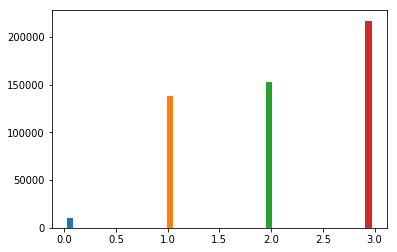

In [79]:
lbl, cnts = np.unique(y_pred, return_counts=True)
print(list(zip(lbl, cnts)))
print(lbl)
print(cnts)

# labels = 
# counts = 

plt.hist((cnts[0]*[lbl[0]],cnts[1]*[lbl[1]],cnts[2]*[lbl[2]],cnts[3]*[lbl[3]]))

[(0, 162441), (1, 125592), (2, 153503), (3, 76920)]
[0 1 2 3]
[162441 125592 153503  76920]


([array([162441.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.]),
  array([     0.,      0.,      0., 125592.,      0.,      0.,      0.,
              0.,      0.,      0.]),
  array([     0.,      0.,      0.,      0.,      0.,      0., 153503.,
              0.,      0.,      0.]),
  array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 76920.])],
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 4 Lists of Patches objects>)

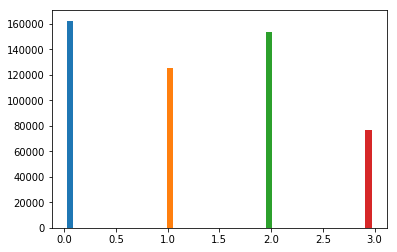

In [81]:
lbl, cnts = np.unique(test_y, return_counts=True)
print(list(zip(lbl, cnts)))
print(lbl)
print(cnts)

# labels = 
# counts = 

plt.hist((cnts[0]*[lbl[0]],cnts[1]*[lbl[1]],cnts[2]*[lbl[2]],cnts[3]*[lbl[3]]))

In [75]:
from sklearn.metrics import average_precision_score
    

average_precision = average_precision_score(y_pred,test_y)

print('Average precision score: {0:0.2f}'.format(
      average_precision))

ValueError: multiclass format is not supported

In [ ]:
from sklearn.metrics import average_precision_score
    

average_precision = average_precision_score(y_pred,test_y)

print('Average precision score: {0:0.2f}'.format(
      average_precision))

In [ ]:
print('a')